# Lab 6: RNN vs LSTM for Fake News Classification

This notebook implements the assignment **"RNN vs LSTM for Fake News Classification"** from the Machine Learning course.  
We compare a simple RNN and an LSTM neural network for binary classification of news (real vs fake).

**Dataset:** Kaggle – *Fake and Real News Dataset* (files `True.csv` and `Fake.csv`).

## Notebook structure

1. Imports, config and helper utils  
2. Loading and preprocessing the data  
3. Building vocabulary and text-to-index pipeline  
4. Train / validation / test split and DataLoaders  
5. RNN and LSTM model implementations in PyTorch  
6. Training loop and metric computation (Accuracy, Precision, Recall, F1, ROC AUC)  
7. Experiments for RNN and LSTM, comparison  
8. Plots: loss curves, F1/accuracy curves, confusion matrix, ROC curve  
9. Short conclusions

> **Note:** This notebook is designed so that you can run it on your own machine / Colab.  
> Just put `True.csv` and `Fake.csv` in the same folder as this notebook or update the paths in the config cell.


In [18]:
import os
import re
import random
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
)

# reproducibility (наскільки це можливо)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [19]:
# === CONFIG (можеш сміливо під себе підкрутити) ===

DATA_DIR = "."  # folder with True.csv and Fake.csv
TRUE_PATH = os.path.join(DATA_DIR, "True.csv")
FAKE_PATH = os.path.join(DATA_DIR, "Fake.csv")

USE_TITLE = True          # if True -> use "title + text", else only "text"
MAX_VOCAB_SIZE = 30000    # max number of tokens in vocabulary
MIN_FREQ = 2              # min frequency for token to be kept in vocab
MAX_LEN = 300             # max sequence length (tokens); longer will be truncated

BATCH_SIZE = 64
NUM_EPOCHS = 5            # for serious training можна збільшити (10–15+)
LR = 1e-3
DROPOUT = 0.2

EMB_DIM = 100
HIDDEN_DIM = 128
NUM_LAYERS = 1
BIDIRECTIONAL_LSTM = True  # only affects LSTM

PRINT_EVERY = 100          # how often to print training progress (in batches)

# special tokens
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"

PAD_IDX = 0
UNK_IDX = 1

In [20]:
# === 1. Loading the dataset ===

df_true = pd.read_csv(TRUE_PATH)
df_fake = pd.read_csv(FAKE_PATH)

# Add labels: 0 = real (True.csv), 1 = fake (Fake.csv)
df_true["label"] = 0
df_fake["label"] = 1

df = pd.concat([df_true, df_fake], ignore_index=True)

# Optional: shuffle
df = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print("Total samples:", len(df))
print("Real news:", (df.label == 0).sum())
print("Fake news:", (df.label == 1).sum())
df.head()

Total samples: 44898
Real news: 21417
Fake news: 23481


,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",1
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",1
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",1
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",0
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",1


In [21]:
# === 2. Text preprocessing & tokenization ===

def clean_text(text: str) -> str:
    """Simple text cleaning:
    - lowercasing
    - remove non-letter characters except basic punctuation (keeps . , ! ? ; :)
    - collapse multiple spaces
    """
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    # keep letters, digits and basic punctuation (note: we intentionally omit keeping quote chars here to avoid string escaping issues), replace others with space
    text = re.sub(r"[^a-z0-9\.,!?;:\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


def tokenize(text: str):
    """Very simple whitespace tokenizer. 
    You can plug in NLTK / spaCy here if you want."""
    return text.split()


# make sure title/text exist and have no NaN (safer than per-row KeyError)
if 'title' in df.columns:
    df['title'] = df['title'].fillna('')
else:
    df['title'] = ''
if 'text' in df.columns:
    df['text'] = df['text'].fillna('')
else:
    df['text'] = ''

def prepare_text_column(row):
    # safer per-row getter and NaN handling
    title = row.get('title', '')
    text_val = row.get('text', '')
    if pd.isna(title):
        title = ''
    if pd.isna(text_val):
        text_val = ''
    if USE_TITLE:
        full = f"{title} {text_val}"
    else:
        full = text_val
    return clean_text(full)


# create a single text column (vectorized where possible)
df["full_text"] = df.apply(prepare_text_column, axis=1)

# quick sanity check
df[["full_text", "label"]].head()

,full_text,label
0,breaking: gop chairman grassley has had enough...,1
1,failed gop candidates remembered in hilarious ...,1
2,mike pence s new dc neighbors are hilariously ...,1
3,california ag pledges to defend birth control ...,0
4,az ranchers living on us mexico border destroy...,1


In [22]:
# === 3. Build vocabulary and numericalize ===

def build_vocab(texts, max_size=MAX_VOCAB_SIZE, min_freq=MIN_FREQ):
    counter = Counter()
    for txt in texts:
        tokens = tokenize(txt)
        counter.update(tokens)
    # most common tokens with frequency filter
    sorted_tokens = [tok for tok, freq in counter.most_common() if freq >= min_freq]
    if max_size is not None:
        sorted_tokens = sorted_tokens[: max_size - 2]  # -2 for PAD and UNK
    # make vocab dict
    idx2token = [PAD_TOKEN, UNK_TOKEN] + sorted_tokens
    token2idx = {tok: idx for idx, tok in enumerate(idx2token)}
    return token2idx, idx2token


token2idx, idx2token = build_vocab(df["full_text"].tolist())
vocab_size = len(idx2token)
print("Vocab size:", vocab_size)


def encode_text(text, token2idx=token2idx, max_len=MAX_LEN):
    tokens = tokenize(text)
    idxs = [token2idx.get(tok, UNK_IDX) for tok in tokens]
    # pad / truncate
    if len(idxs) < max_len:
        idxs = idxs + [PAD_IDX] * (max_len - len(idxs))
    else:
        idxs = idxs[:max_len]
    return np.array(idxs, dtype=np.int64)


# Apply encoding to all texts (this might take some time)
encoded_texts = np.stack(df["full_text"].apply(encode_text).values)
labels = df["label"].values.astype(np.int64)

print("Encoded texts shape:", encoded_texts.shape)
print("Labels shape:", labels.shape)

Vocab size: 30000
Encoded texts shape: (44898, 300)
Labels shape: (44898,)
Encoded texts shape: (44898, 300)
Labels shape: (44898,)


In [23]:
# === 4. Train / validation / test split ===

X_temp, X_test, y_temp, y_test = train_test_split(
    encoded_texts, labels, test_size=0.1, random_state=SEED, stratify=labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, random_state=SEED, stratify=y_temp
)  # 0.1111 * 0.9 ≈ 0.1 => 80/10/10

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

Train size: 35918
Val size: 4490
Test size: 4490


In [24]:
# === 5. PyTorch Dataset and DataLoaders ===

class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = NewsDataset(X_train, y_train)
val_dataset = NewsDataset(X_val, y_val)
test_dataset = NewsDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
# Use num_workers=0 in notebooks to avoid multiprocessing/pickling issues on macOS/Windows
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())

len(train_loader), len(val_loader), len(test_loader)

(562, 71, 71)

In [25]:
# === 6. Model definitions: Simple RNN and LSTM ===

class SimpleRNNClassifier(nn.Module):
    def __init__(
        self, vocab_size, emb_dim, hidden_dim,
        num_layers=1, dropout=0.2, padding_idx=PAD_IDX
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)
        self.rnn = nn.RNN(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            nonlinearity='tanh',
            dropout=(dropout if num_layers > 1 else 0.0),
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (B, L)
        emb = self.embedding(x)          # (B, L, emb_dim)
        out, h_n = self.rnn(emb)         # h_n: (num_layers, B, H)
        last = h_n[-1]                   # (B, H)
        logits = self.fc(last).squeeze(1)  # (B,)
        probs = torch.sigmoid(logits)
        return probs, logits


class LSTMClassifier(nn.Module):
    def __init__(
        self, vocab_size, emb_dim, hidden_dim,
        num_layers=1, bidirectional=False, dropout=0.2, padding_idx=PAD_IDX
    ):
        super().__init__()
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=(dropout if num_layers > 1 else 0.0),
        )
        factor = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_dim * factor, 1)

    def forward(self, x):
        # x: (B, L)
        emb = self.embedding(x)                 # (B, L, emb_dim)
        out, (h_n, c_n) = self.lstm(emb)
        if self.bidirectional:
            # h_n: (num_layers * 2, B, H)
            # last forward + last backward
            last_forward = h_n[-2]
            last_backward = h_n[-1]
            last = torch.cat([last_forward, last_backward], dim=1)  # (B, 2H)
        else:
            last = h_n[-1]                     # (B, H)
        logits = self.fc(last).squeeze(1)      # (B,)
        probs = torch.sigmoid(logits)
        return probs, logits

In [26]:
# === 7. Training utilities ===

def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    try:
        roc_auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        roc_auc = float('nan')
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
    }


def run_epoch(model, data_loader, criterion, optimizer=None):
    """If optimizer is None => evaluation mode."""
    if optimizer is None:
        model.eval()
    else:
        model.train()

    epoch_loss = 0.0
    all_probs = []
    all_labels = []

    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE).float()  # (B,)

        if optimizer is not None:
            optimizer.zero_grad()

        with torch.set_grad_enabled(optimizer is not None):
            probs, logits = model(x_batch)
            loss = criterion(logits, y_batch)
            if optimizer is not None:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                optimizer.step()

        epoch_loss += loss.item() * x_batch.size(0)
        all_probs.append(probs.detach().cpu().numpy())
        all_labels.append(y_batch.detach().cpu().numpy())

    epoch_loss /= len(data_loader.dataset)
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels).astype(int)
    metrics = compute_metrics(all_labels, all_probs)

    return epoch_loss, metrics, all_probs, all_labels


def train_model(model, train_loader, val_loader, num_epochs=NUM_EPOCHS, lr=LR):
    model.to(DEVICE)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_f1": [],
        "val_f1": [],
        "val_roc_auc": [],
    }

    best_val_f1 = -1.0
    best_state = None

    for epoch in range(1, num_epochs + 1):
        train_loss, train_metrics, _, _ = run_epoch(
            model, train_loader, criterion, optimizer=optimizer
        )
        val_loss, val_metrics, _, _ = run_epoch(
            model, val_loader, criterion, optimizer=None
        )

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_f1"].append(train_metrics["f1"])
        history["val_f1"].append(val_metrics["f1"])
        history["val_roc_auc"].append(val_metrics["roc_auc"])

        print(
            f"Epoch {epoch}/{num_epochs} | "
            f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
            f"train_f1={train_metrics['f1']:.4f}, val_f1={val_metrics['f1']:.4f}, "
            f"val_roc_auc={val_metrics['roc_auc']:.4f}"
        )

        if val_metrics["f1"] > best_val_f1:
            best_val_f1 = val_metrics["f1"]
            best_state = model.state_dict()

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history

In [27]:
# === 8. Helper to run RNN / LSTM experiment ===

def run_experiment(
    model_type="rnn",
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    bidirectional_lstm=BIDIRECTIONAL_LSTM,
    dropout=DROPOUT,
    num_epochs=NUM_EPOCHS,
    lr=LR,
):
    if model_type.lower() == "rnn":
        model = SimpleRNNClassifier(
            vocab_size=vocab_size,
            emb_dim=emb_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            padding_idx=PAD_IDX,
        )
    elif model_type.lower() == "lstm":
        model = LSTMClassifier(
            vocab_size=vocab_size,
            emb_dim=emb_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional_lstm,
            dropout=dropout,
            padding_idx=PAD_IDX,
        )
    else:
        raise ValueError("model_type must be 'rnn' or 'lstm'")

    print(f"\n=== Training {model_type.upper()} model ===")
    model, history = train_model(
        model,
        train_loader,
        val_loader,
        num_epochs=num_epochs,
        lr=lr,
    )

    # final evaluation on test set
    criterion = nn.BCEWithLogitsLoss()
    test_loss, test_metrics, test_probs, test_labels = run_epoch(
        model, test_loader, criterion, optimizer=None
    )

    print("\n=== Test results for", model_type.upper(), "===")
    print("Test loss:", round(test_loss, 4))
    for k, v in test_metrics.items():
        print(f"{k}: {v:.4f}")

    results = {
        "model": model,
        "history": history,
        "test_loss": test_loss,
        "test_metrics": test_metrics,
        "test_probs": test_probs,
        "test_labels": test_labels,
    }
    return results

In [28]:
# === 9. Run baseline experiments for RNN and LSTM ===
# Quick-run safety: if your machine is slow, set QUICK_RUN = True to train on a small subset for 1 epoch
# На повному датасеті це може зайняти помітний час.

QUICK_RUN = True  # change to False to run full experiments
SMOKE_TRAIN_SIZE = 5000
SMOKE_VAL_SIZE = 1000
SMOKE_TEST_SIZE = 1000

# backup original loaders (so we can restore them later)
_orig_train_loader, _orig_val_loader, _orig_test_loader = train_loader, val_loader, test_loader

if QUICK_RUN:
    # build small subsets for a fast smoke-test
    N = min(SMOKE_TRAIN_SIZE, len(X_train))
    rng = np.random.RandomState(SEED)
    idx = rng.choice(len(X_train), size=N, replace=False)
    X_tr_small = X_train[idx]
    y_tr_small = y_train[idx]
    idx_val = rng.choice(len(X_val), size=min(SMOKE_VAL_SIZE, len(X_val)), replace=False)
    X_val_small = X_val[idx_val]
    y_val_small = y_val[idx_val]
    idx_test = rng.choice(len(X_test), size=min(SMOKE_TEST_SIZE, len(X_test)), replace=False)
    X_test_small = X_test[idx_test]
    y_test_small = y_test[idx_test]

    train_loader = DataLoader(NewsDataset(X_tr_small, y_tr_small), batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
    val_loader = DataLoader(NewsDataset(X_val_small, y_val_small), batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())
    test_loader = DataLoader(NewsDataset(X_test_small, y_test_small), batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())
    # In notebooks keep num_workers=0 to avoid worker pickling errors (NewsDataset is defined in the notebook).
    train_loader = DataLoader(NewsDataset(X_tr_small, y_tr_small), batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=torch.cuda.is_available())
    val_loader = DataLoader(NewsDataset(X_val_small, y_val_small), batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())
    test_loader = DataLoader(NewsDataset(X_test_small, y_test_small), batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())

# reduce epochs for quick run
run_epochs = 1 if QUICK_RUN else NUM_EPOCHS

# Run RNN (with KeyboardInterrupt handling)
try:
    rnn_results = run_experiment(
        model_type="rnn",
        emb_dim=EMB_DIM,
        hidden_dim=HIDDEN_DIM,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT,
        num_epochs=run_epochs,
        lr=LR,
    )
except KeyboardInterrupt:
    print("RNN training interrupted by user")
    rnn_results = None

# Run LSTM (with KeyboardInterrupt handling)
try:
    lstm_results = run_experiment(
        model_type="lstm",
        emb_dim=EMB_DIM,
        hidden_dim=HIDDEN_DIM,
        num_layers=NUM_LAYERS,
        bidirectional_lstm=BIDIRECTIONAL_LSTM,
        dropout=DROPOUT,
        num_epochs=run_epochs,
        lr=LR,
    )
except KeyboardInterrupt:
    print("LSTM training interrupted by user")
    lstm_results = None

# restore original loaders (important if other cells rely on them)
train_loader, val_loader, test_loader = _orig_train_loader, _orig_val_loader, _orig_test_loader

print(f'Done (quick_run={QUICK_RUN}).')


=== Training RNN model ===
Epoch 1/1 | train_loss=0.6937, val_loss=0.6876, train_f1=0.5911, val_f1=0.5597, val_roc_auc=0.5639
Epoch 1/1 | train_loss=0.6937, val_loss=0.6876, train_f1=0.5911, val_f1=0.5597, val_roc_auc=0.5639

=== Test results for RNN ===
Test loss: 0.6748
accuracy: 0.5520
precision: 0.6050
recall: 0.4954
f1: 0.5447
roc_auc: 0.5832

=== Training LSTM model ===

=== Test results for RNN ===
Test loss: 0.6748
accuracy: 0.5520
precision: 0.6050
recall: 0.4954
f1: 0.5447
roc_auc: 0.5832

=== Training LSTM model ===
Epoch 1/1 | train_loss=0.3853, val_loss=0.0448, train_f1=0.8410, val_f1=0.9955, val_roc_auc=0.9995
Epoch 1/1 | train_loss=0.3853, val_loss=0.0448, train_f1=0.8410, val_f1=0.9955, val_roc_auc=0.9995

=== Test results for LSTM ===
Test loss: 0.0653
accuracy: 0.9910
precision: 0.9854
recall: 0.9982
f1: 0.9917
roc_auc: 0.9987
Done (quick_run=True).

=== Test results for LSTM ===
Test loss: 0.0653
accuracy: 0.9910
precision: 0.9854
recall: 0.9982
f1: 0.9917
roc_auc: 

Short history values:
RNN history: {'train_loss': [0.6937354974746704], 'val_loss': [0.6875629849433899], 'train_f1': [0.5911480413769713], 'val_f1': [0.559679037111334], 'val_roc_auc': [0.5638542158512618]}
LSTM history: {'train_loss': [0.38527180130183697], 'val_loss': [0.04477547979354858], 'train_f1': [0.8410434782608696], 'val_f1': [0.9954504094631483], 'val_roc_auc': [0.9994793999782075]}


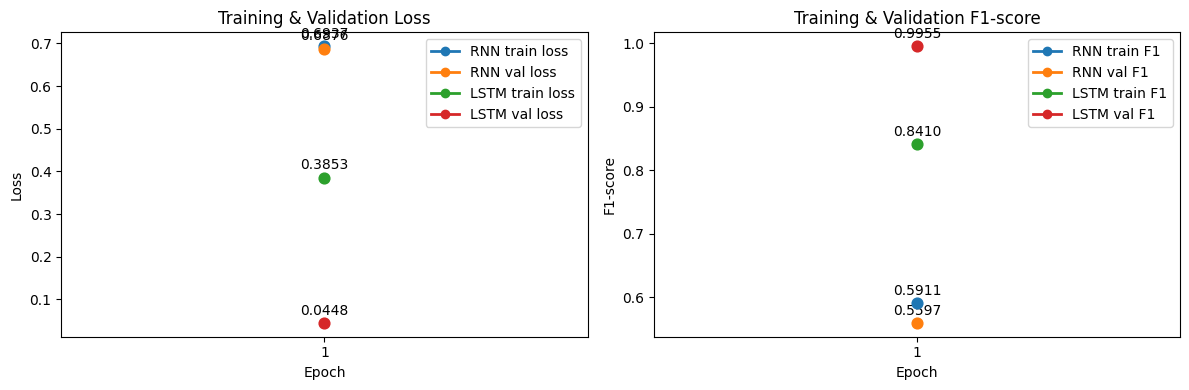

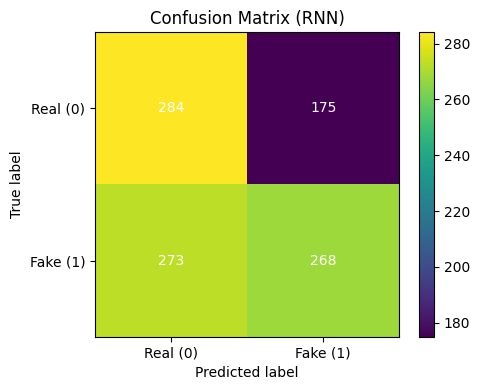

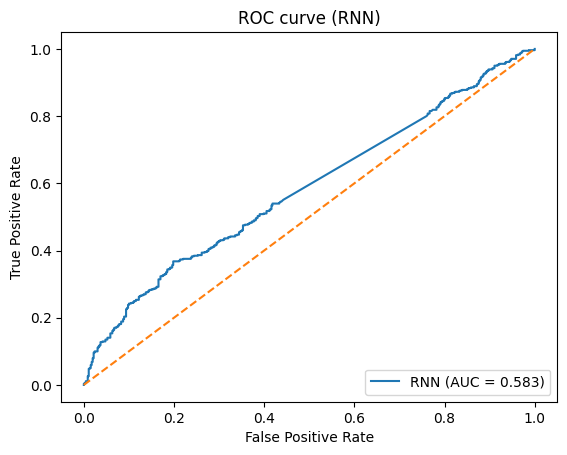

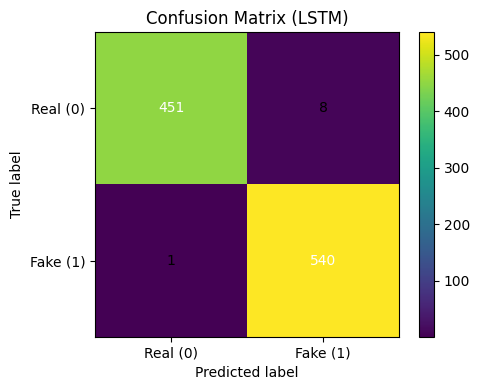

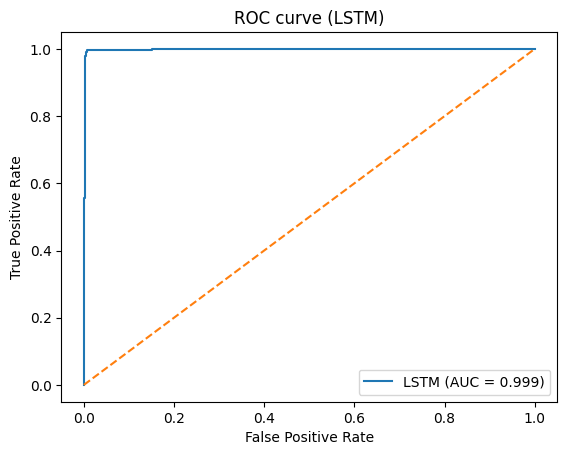

In [31]:
# === 10. Visualization: loss curves, F1, confusion matrix, ROC ===

def plot_history(history_rnn, history_lstm):
    """Plot training/validation loss and F1 for RNN and LSTM."""
    # safe getters (history may be a dict from train_model)
    def _get(h, key):
        return list(h.get(key, [])) if isinstance(h, dict) else []

    train_loss_r = _get(history_rnn, 'train_loss')
    val_loss_r = _get(history_rnn, 'val_loss')
    train_loss_l = _get(history_lstm, 'train_loss')
    val_loss_l = _get(history_lstm, 'val_loss')

    train_f1_r = _get(history_rnn, 'train_f1')
    val_f1_r = _get(history_rnn, 'val_f1')
    train_f1_l = _get(history_lstm, 'train_f1')
    val_f1_l = _get(history_lstm, 'val_f1')

    n_epochs = max(len(train_loss_r), len(train_loss_l), len(train_f1_r), len(train_f1_l), 1)
    epochs = list(range(1, n_epochs + 1))

    plt.figure(figsize=(12, 4))
    # helper to plot with markers and handle single-point cases
    def safe_plot(xs, ys, label, **kwargs):
        if len(ys) == 0:
            return
        plt.plot(xs[:len(ys)], ys, label=label, marker='o', linewidth=2, **kwargs)
        if len(ys) == 1:
            # make single point visible and annotate
            plt.scatter(xs[0], ys[0], s=60, zorder=5)
            try:
                plt.annotate(f"{ys[0]:.4f}", (xs[0], ys[0]), textcoords="offset points", xytext=(0, 6), ha="center")
            except Exception:
                pass

    # Loss subplot
    plt.subplot(1, 2, 1)
    safe_plot(epochs, train_loss_r, 'RNN train loss')
    safe_plot(epochs, val_loss_r, 'RNN val loss')
    safe_plot(epochs, train_loss_l, 'LSTM train loss')
    safe_plot(epochs, val_loss_l, 'LSTM val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.xticks(epochs)
    plt.legend()

    # F1 subplot
    plt.subplot(1, 2, 2)
    safe_plot(epochs, train_f1_r, 'RNN train F1')
    safe_plot(epochs, val_f1_r, 'RNN val F1')
    safe_plot(epochs, train_f1_l, 'LSTM train F1')
    safe_plot(epochs, val_f1_l, 'LSTM val F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.title('Training & Validation F1-score')
    plt.xticks(epochs)
    plt.legend()

    plt.tight_layout()
    # if history is very short, print values for debugging
    if n_epochs <= 2:
        print('Short history values:')
        print('RNN history:', history_rnn)
        print('LSTM history:', history_lstm)
    plt.show()


def plot_confusion_and_roc(results, model_name="Model"):
    y_true = results["test_labels"]
    y_prob = results["test_probs"]
    y_pred = (y_prob >= 0.5).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix ({model_name})")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Real (0)", "Fake (1)"])
    plt.yticks(tick_marks, ["Real (0)", "Fake (1)"])
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.show()

    # ROC curve
    try:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = roc_auc_score(y_true, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC curve ({model_name})")
        plt.legend(loc="lower right")
        plt.show()
    except ValueError:
        print("ROC curve cannot be computed (only one class present?).")


# Example usage AFTER training both models (safe checks):
# If you ran the training cells, rnn_results and lstm_results should be present.
# The block below will only attempt plotting if results exist and will print helpful messages otherwise.

if 'rnn_results' in globals() and rnn_results is not None and 'lstm_results' in globals() and lstm_results is not None:
    try:
        plot_history(rnn_results['history'], lstm_results['history'])
    except Exception as e:
        print('Could not plot history:', e)

if 'rnn_results' in globals() and rnn_results is not None:
    try:
        plot_confusion_and_roc(rnn_results, model_name='RNN')
    except Exception as e:
        print('Could not plot RNN confusion/ROC:', e)
else:
    print('rnn_results missing or training was interrupted; skipping RNN plots')

if 'lstm_results' in globals() and lstm_results is not None:
    try:
        plot_confusion_and_roc(lstm_results, model_name='LSTM')
    except Exception as e:
        print('Could not plot LSTM confusion/ROC:', e)
else:
    print('lstm_results missing or training was interrupted; skipping LSTM plots')

## 11. Short conclusions (template)

Here you should briefly summarize your experimental findings for the report:

- Which model (RNN or LSTM) achieved higher F1-score on the test set?  
- How do their ROC AUC scores compare?  
- Did bidirectional LSTM help?  
- Which model was faster per epoch / smaller in terms of parameters?  
- Any signs of overfitting or underfitting in the curves?  

You can then reuse plots and metrics from this notebook in your final written report (Part F of the assignment).